In [155]:
%matplotlib inline
%load_ext memory_profiler

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

In [59]:
# label format: PID-GA-FEMALE_FLAG
data = {}

print('Loading data into dict:')
counter = 0
tic = time.time()
for folder in glob.glob('/home/ngr/gdrive/wearables/data/MOD_1000_Woman_Activity_Data/*'):
    for file in glob.glob(os.path.join(folder, '*GA*.csv')):
            dt = pd.read_csv(file)
            
            f = os.path.split(file)[1]
            f = f.replace(' ', '')
            if '_' in f:
                pid, f = f.split('_GA')
            elif '-' in f:
                pid, f = f.split('-GA')
            GA = int(f.split('.csv')[0])
            
            if dt.loc[dt['UserID']=='Sex'].shape[0] == 0:
                sex_female = 'NA'             
            else:
                sex_female = 1 if 'fem' in dt.loc[dt['UserID']=='Sex'].iloc[:, 1].values[0].lower() else 0
                
            for i, row0 in enumerate(dt.iloc[:, 0]):
                if isinstance(row0, str):
                    if np.sum([True if '/' in ii else False for ii in row0]) == 2:
                        row_idx_start = i
                        break
                        
            idx = dt.iloc[row_idx_start:, 0].loc[(~dt.iloc[row_idx_start:, [0,1,2]].isna().any(1)) == True].index.to_list()
            t = pd.to_datetime(dt.iloc[idx, 0].astype(str) + ' ' + dt.iloc[idx, 1].astype(str), format='%m/%d/%Y %I:%M:%S %p',)
            activity = dt.iloc[idx, 2] # MW counts
            data['{}-{}-{}'.format(pid, GA, sex_female)] = [t.to_list(), activity.to_list()]
            counter += 1
            
            if counter % 100 == 0 :
                print('.. through {} graphs in {:.0f}-s'.format(counter, time.time() - tic))
                
print('\n... {} graphs loaded in {:.1f}-min'.format(counter, (time.time() - tic)/60))

Through 100 graphs in 35-s


/home/ngr/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Through 200 graphs in 73-s
Through 300 graphs in 99-s
Through 400 graphs in 124-s
Through 500 graphs in 148-s
Through 600 graphs in 168-s
Through 700 graphs in 196-s
Through 800 graphs in 217-s
Through 900 graphs in 264-s
Through 1000 graphs in 330-s
Through 1100 graphs in 387-s
Through 1200 graphs in 457-s
Through 1300 graphs in 523-s
Through 1400 graphs in 602-s
Through 1500 graphs in 631-s
Through 1600 graphs in 655-s
Through 1700 graphs in 675-s
Through 1800 graphs in 704-s
Through 1900 graphs in 721-s
Through 2000 graphs in 742-s
Through 2100 graphs in 762-s
Through 2200 graphs in 782-s
Through 2300 graphs in 803-s
Through 2400 graphs in 837-s
Through 2500 graphs in 858-s
Through 2600 graphs in 877-s


In [62]:
def pkl_that(data, fname, verbose=True):
    import pickle
    if not os.path.exists(os.path.split(fname)[0]):
        os.mkdir(os.path.split(fname)[0])
    tic = time.time()
    with open(fname, 'wb') as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
        f.close()
    if verbose:
        print('Wrote data to {} in {:.0f}-s'.format(fname, time.time() - tic))
    return None

In [63]:
pkl_that(data, '/home/ngr/gdrive/wearables/data/processed/MOD_1000_Woman_Activity_Data.pkl')

Wrote data to /home/ngr/gdrive/wearables/data/processed/MOD_1000_Woman_Activity_Data.pkl in 224-s


In [145]:
def tx2coo(data, verbose=True):
    '''
    Returns:
      list (pid-GA-femaleflag), torch.sparse_coo (m samples x n timepoints)
    '''
    y = []
    max_tn = 0
    if verbose:
        print('Loading time-series in dict to torch sparse tensor (coo format)...')
        tic = time.time()
    for i, (k, v) in enumerate(data.items()):
        if len(v[1]) >= max_tn: # reset max number of time points
            max_tn = len(v[1])
        y.append(k)
        if i == 0:
            X_idx = np.array([np.repeat(i, len(v[1])), np.arange(len(v[1]))])
            X_val = np.array([float(ii) for ii in v[1]]) # v[0] are datetimes
        else:
            idx = np.array([np.repeat(i, len(v[1])), np.arange(len(v[1]))])
            val = np.array([float(ii) for ii in v[1]]) # v[0] are datetimes
            
            X_idx = np.concatenate((X_idx, idx), 1)
            X_val = np.append(X_val, val)
        if verbose and i % 100 == 0 and i != 0:
            print('... through {} graphs in {:.0f}-s'.format(i+1, time.time() - tic))
    return y, torch.sparse_coo_tensor(torch.tensor(X_idx), torch.tensor(X_val), (len(data.keys()), max_tn))
        

In [146]:
y, X = tx2coo(data)

Loading time-series in dict to torch sparse tensor (coo format)...
... through 101 graphs in 6-s
... through 201 graphs in 24-s
... through 301 graphs in 51-s
... through 401 graphs in 86-s
... through 501 graphs in 127-s
... through 601 graphs in 174-s
... through 701 graphs in 229-s
... through 801 graphs in 292-s
... through 901 graphs in 363-s
... through 1001 graphs in 442-s
... through 1101 graphs in 526-s
... through 1201 graphs in 618-s
... through 1301 graphs in 714-s
... through 1401 graphs in 820-s
... through 1501 graphs in 953-s
... through 1601 graphs in 1101-s
... through 1701 graphs in 1339-s
... through 1801 graphs in 1640-s
... through 1901 graphs in 1960-s
... through 2001 graphs in 2143-s
... through 2101 graphs in 2334-s
... through 2201 graphs in 2532-s
... through 2301 graphs in 2741-s
... through 2401 graphs in 2944-s
... through 2501 graphs in 3136-s
... through 2601 graphs in 3333-s


In [149]:
def ystr2df(y):
    pid, GA, female = [], [], []
    for i, yy in enumerate(y):
        pid_i, GA_i, female_i = yy.split('-')
        pid.append(pid_i)
        GA.append(int(GA_i))
        female.append(np.nan if female_i=='NA' else int(female_i))
    dt = pd.DataFrame({'pid':pid, 'GA':GA, 'female':female})
    return dt


In [150]:
md = ystr2df(y)

In [151]:
pkl_that({'y':md, 'X':X}, '/home/ngr/gdrive/wearables/data/processed/MOD1k_GAactigraphy_torchsparse.pkl')

Wrote data to /home/ngr/gdrive/wearables/data/processed/MOD1k_GAactigraphy_torchsparse.pkl in 6-s


In [153]:
X_pdist = torch.nn.PairwiseDistance(p=2)(X, X)

RuntimeError: add(sparse, dense) is not supported. Use add(dense, sparse) instead.

In [156]:
%%memit 
Xdense = X.to_dense()

peak memory: 32061.68 MiB, increment: 8065.66 MiB


In [160]:
# try adata things
import scanpy as sc

In [164]:
%%memit
adata = sc.AnnData(X=Xdense.numpy(), obs=md)

peak memory: 29401.91 MiB, increment: 1351.23 MiB


In [166]:
sc.tl.pca(adata, n_comps=20)
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=20)
sc.tl.leiden(adata)
sc.tl.umap(adata)

In [195]:
# add feature of how many zeros are padded\
idx = X.coalesce().indices()
dt = pd.DataFrame({'i':idx[0, :].numpy(), 'j':idx[1, :].numpy()})
adata.obs['n_timepoints'] = dt.groupby('i').max().reset_index()['j'].to_list()

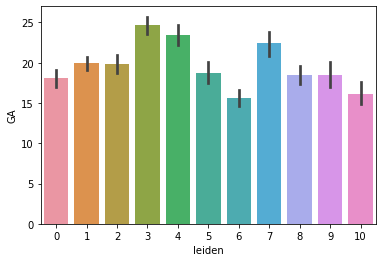

In [196]:
sns.barplot(x='leiden', y='GA', data=adata.obs)

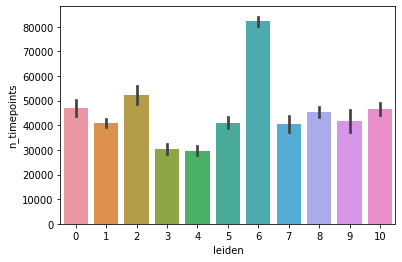

In [198]:
sns.barplot(x='leiden', y='n_timepoints', data=adata.obs)

In [199]:
# add birth classification
adata.obs['Birth classification'] = np.nan
adata.obs.loc[(adata.obs['GA']<=37), 'Birth classification'] = 'Preterm'
adata.obs.loc[(adata.obs['GA']==38), 'Birth classification'] = 'Early term'
adata.obs.loc[(adata.obs['GA']==39) | (adata.obs['GA']==40), 'Birth classification'] = 'Full term'
adata.obs.loc[(adata.obs['GA']>40), 'Birth classification'] = 'Late term'

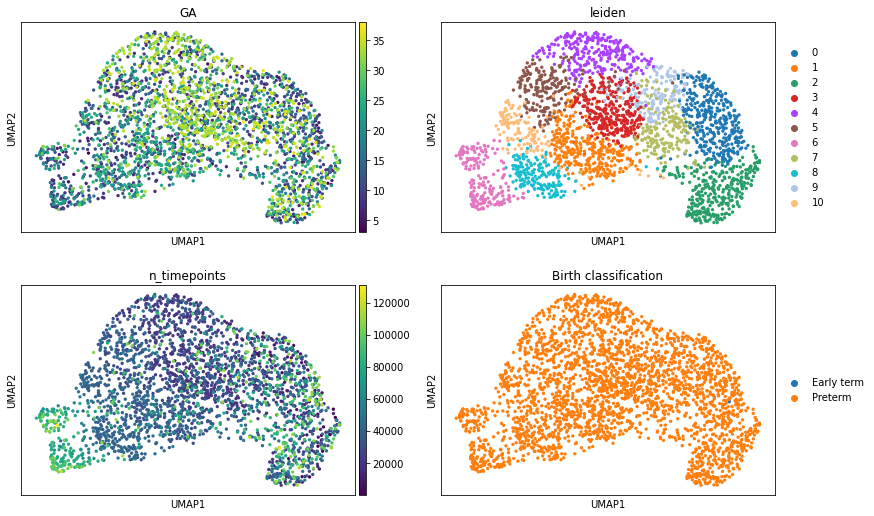

In [203]:
sc.pl.umap(adata, color=['GA', 'leiden', 'n_timepoints', 'Birth classification'], ncols=2)

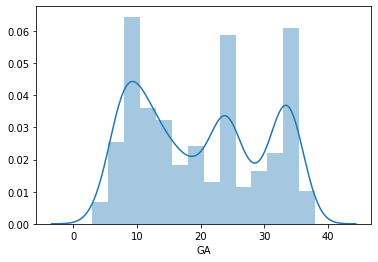

In [205]:
sns.distplot(adata.obs.GA)

In [207]:
np.sort(adata.obs['leiden'].unique())

array(['0', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9'],
      dtype=object)

In [212]:
adata.obs.loc[:, ['GA', 'n_timepoints']].to_numpy().shape

(2686, 2)

In [239]:
np.sort(adata.obs['leiden'].unique().astype(int))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [250]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

results = pd.DataFrame()
X_clusters = adata.obs.loc[:, ['GA', 'n_timepoints']].to_numpy()
# X_clusters[:, 0] = X_clusters[:, 0]/ 10000
for clusterID in np.sort(adata.obs['leiden'].unique().astype(int)):
    y_cid = (adata.obs['leiden'] == str(clusterID)).astype(int)
    clf = LogisticRegression()
    clf.fit(X_clusters, y_cid)
    auc = roc_auc_score(y_cid, clf.predict_proba(X_clusters)[:, 1])
    dt = pd.DataFrame({'leiden':clusterID, 'auc':auc, 'GA':np.exp(clf.coef_[0][0]), 'n':np.exp(clf.coef_[0][1])}, index=[0])
    results = results.append(dt, ignore_index=True)

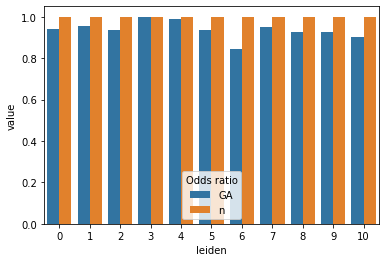

In [251]:
sns.barplot(x='leiden', y='value', hue='Odds ratio', data=pd.melt(results, id_vars=['leiden', 'auc'], var_name='Odds ratio'))

Text(0.5, 1.0, 'LR w/L2 reg.')

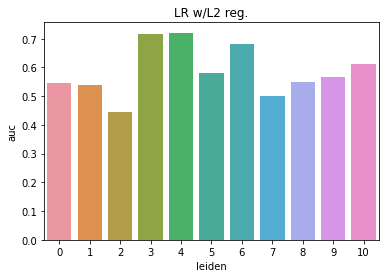

In [253]:
p = sns.barplot(x='leiden', y='auc', data=results)
p.set_title('LR w/L2 reg.')

In [259]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge

# data
X_pca = adata.obsm['X_pca']
y_GA = adata.obs['GA'].to_numpy()

svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1),
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})

kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1),
                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                              "gamma": np.logspace(-2, 2, 5)})

svr.fit(X_pca, y_GA)

kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1),
                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                              "gamma": np.logspace(-2, 2, 5)})
kr.fit(X_pca, y_GA)

GridSearchCV(estimator=SVR(gamma=0.1),
             param_grid={'C': [1.0, 10.0, 100.0, 1000.0],
                         'gamma': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])})

In [265]:
svr.best_estimator_

SVR(C=100.0, gamma=0.1)

In [263]:
kr.best_estimator_

KernelRidge(alpha=0.001, gamma=0.01, kernel='rbf')

In [268]:
svr = SVR(C=100.0, gamma=0.1)
svr.fit(X_pca, y_GA)
y_svr = svr.predict(X_pca)

In [266]:
kr = KernelRidge(alpha=0.001, gamma=0.01, kernel='rbf')
kr.fit(X_pca, y_GA)
y_kr = kr.predict(X_pca)

In [269]:
# results
from sklearn.metrics import mean_absolute_error

In [274]:
print('SVR MAE: {:.2f}'.format(mean_absolute_error(y_GA, y_svr)))

SVR MAE: 0.10


In [273]:
print('KR MAE: {:.2f}'.format(mean_absolute_error(y_GA, y_kr)))

KR MAE: 0.02


In [277]:
idx = np.argsort(y_GA)

In [284]:
dt = pd.DataFrame({'Rank':np.arange(len(idx)), 'y_GA':y_GA[idx], 'y_SVR':y_svr[idx], 'y_KR':y_kr[idx]})
dt = pd.melt(dt, id_vars='Rank', var_name='Predictor', value_name='GA')

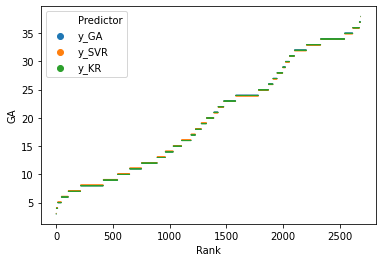

In [290]:
sns.scatterplot(x='Rank', y='GA', hue='Predictor', data=dt, linewidth=0, s=1, alpha=0.6)

In [285]:
dt

,Rank,Predictor,GA
0,0,y_GA,3.000000
1,1,y_GA,3.000000
2,2,y_GA,4.000000
3,3,y_GA,4.000000
4,4,y_GA,4.000000
...,...,...,...
8053,2681,y_KR,36.963035
8054,2682,y_KR,36.963035
8055,2683,y_KR,36.963035
8056,2684,y_KR,36.963035
